# Capstone Project - Compatible Neighborhoods

## Introduction/Business Problem

The high growth in tech companies and the related job market has led to a large migration of professionals from all across America to tech hub cities wanting to take part in new opportunities.  The increase in population in these hub cities led to the exciting new openings of venues and other less desirable changes such as rising rents.  When considering to move to one of these cities, it can be difficult choosing between neighborhoods.  How does one consider a new neighborhood based on data before visiting it?  What information would be useful to help narrow down the choices?

In this project, I explore the use case of a subject living in a high tech hub city wanting to relocate to another one.
Two metropolitan cities are compared - Seattle and San Francisco.  The study provides a mapping of a neighborhood in one city to a similar one in the other by grouping them into clusters.  All neighborhoods within the same cluster are considered compatible.  Compatibility is based on how similarity of neighborhoods based on the types of popular venues present in the neighborhood.

Initial assumptions are:
<ol>
    <li>The subject wants to find a neighborhood that is similar to their current one but in a different city.</li>
    <li>The subject is primarily concerned with the types of popular venues present in the neighborhood.</li>
    <li>The subject is impartial towards climate differences.</li>
    <li>The subject is impartial towards demographics of the city's residents.</li>
    <li>The subject is impartial towards differences in cost between the two cities.</li>
</ol>


## Data

The data for this study consists of a listing of neighborhoods for each city, merged with geo coordinates and venue data from Foursquare.

Neighborhood data is sourced from wikipedia and can appear in different formats per city.  Additional effort may be required to scrape the data.

The geo coordinates of neighborhoods are obtained from geocoding APIs. Geo coordinates are needed when getting venue information from Foursquare.  If the APIs are not available or do not work, the coordinates can be determined manually by using neighborhood location and boundary information from wikipedia and pinpointing the coordinates from google maps or other online geo-coding tool.

Venue information consists of venue type and frequency of visits and is obtained from Foursquare by specifying the geo coordinates of a location and the search radius.

If time and APIs allow, I would like to consider the hours of operations and popular times for the most popular venues in the borough.  These require premium API calls, so I may not be able to collect the data, or the data will be limited.

Python data frames are used to hold the data above.  The data in this study is also saved to CSV files and placed in Github.  This allows loading data from CSV instead of APIs and is generally faster and helps prevent excessive API calls.

### Data - Part 1 - Gather Neighborhood and Geocode Data

Getting list of neighborhoods from Wikipedia was a challenge. Neighborhood data on Wikipedia appeared in different formats for each city on Wikipedia include non-tabular format which made scraping the data programatically difficult.  I manually parsed out the neighborhood data from the Wikipedia page and saved them to csv files.

List of URLs to wikipedia:<br/>
<ul>
<li>https://en.wikipedia.org/wiki/List_of_neighborhoods_in_San_Francisco</li>
<li>https://en.wikipedia.org/wiki/List_of_Austin_neighborhoods</li>
<li>https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Seattle</li>
</ul>

As for geocoding, I found that the geocoder library never returns coordinates.  I looked into Google's geocoding APIs and found it requires a paid subscription.

As a workaround, I used google's online geocoder tool to manually gather the coordinates for each neighborhood into a csv format. https://www.mapdevelopers.com/geocode_tool.php

In many cases, the geocoder tool could not locate the neighborhood.  For these cases, I entered the neighborhood into https://maps.google.com and obtained the coordinates by visually pin dropping the center of the neighborhood.

In [32]:
# load packages for panda dataframes, geocoding and mapping
import pandas as pd
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np

#!conda install -c conda-forge geopy --yes # uncomment this line if you see error ModuleNotFoundError: No module named 'Nominatim'
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you see error ModuleNotFoundError: No module named 'folium'
import folium # map rendering library

In [33]:
# For creating a csv download of a dataframe; useful for reducing Foursquare API calls.
from IPython.display import HTML
import base64

def create_download_link( df, title = "Download CSV file", filename = "data.csv"):  
    csv = df.to_csv()
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

In [34]:
# List of cities and URLs at wiki for neighborhoods
CITY_NAMES = ['San Francisco, California', 'Seattle, Washington']
CITY_RADIUS = [1560, 2376] # in meters for exploring venues in Foursquare
CITY_ZOOM_START = [12, 11] # used for rendering folium maps

# urls to csv data in Github
CITY_GEO_CSV_URL = ['https://raw.githubusercontent.com/echoi11/data-capstone/master/San_Francisco_Geo.csv', 'https://raw.githubusercontent.com/echoi11/data-capstone/master/Seattle_Geo.csv']
CITY_VENUE_CSV = ['https://raw.githubusercontent.com/echoi11/data-capstone/master/San_Francisco_Venues.csv', 'https://raw.githubusercontent.com/echoi11/data-capstone/master/Seattle_Venues.csv']

In [35]:
# function for loading neighborhoods and geos
def loadCityData(city_index) :
    df_neigh = pd.read_csv(CITY_GEO_CSV_URL[city_index])
    print('{} has {} neighborhoods.'.format(
        CITY_NAMES[city_index],
        df_neigh.shape[0]
    )
         )
    return df_neigh

In [36]:
# create map using latitude and longitude values
def mapOfCity(city_index, city_data) :
    address = CITY_NAMES[city_index]

    geolocator = Nominatim(user_agent="us_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    print('The geograpical coordinate of {} are {}, {}.'.format(address, latitude, longitude))

    map_city = folium.Map(location=[latitude, longitude], zoom_start=CITY_ZOOM_START[city_index])

    # add markers to map
    for lat, lng, neighborhood in zip(city_data['Latitude'], city_data['Longitude'], city_data['Neighborhood']):
        label = '{}'.format(neighborhood)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map_city)  

    return map_city

### Map of San Francisco Neighborhoods

In [37]:
# Load San Francisco city data and map it using folium
sf_city_data = loadCityData(0)
sf_map = mapOfCity(0, sf_city_data)
sf_map

San Francisco, California has 120 neighborhoods.
The geograpical coordinate of San Francisco, California are 37.7790262, -122.4199061.


### Map of Seattle Neighborhoods

In [38]:
# Load Seattle city data and map it using folium
se_city_data = loadCityData(1)
se_map = mapOfCity(1, se_city_data)
se_map

Seattle, Washington has 124 neighborhoods.
The geograpical coordinate of Seattle, Washington are 47.6038321, -122.3300624.


### Data - Part 2 - Get Venue Data from Foursquare API

In [39]:
import requests

CLIENT_ID = 'abcd' # your Foursquare ID
CLIENT_SECRET = 'abcd' # your Foursquare Secret
VERSION = '20200414' # Foursquare API version
LIMIT = 100

In [40]:
# The code was removed by Watson Studio for sharing.

In [41]:
# create a function to get venues for each neighborhood
def getNearbyVenues(city_index, city_data, load_from_csv):

    if load_from_csv :
        # load from csv
        print("Loading venues from csv ...")
        nearby_venues = pd.read_csv(CITY_VENUE_CSV[city_index])
        print("Loading venues from csv completed")
        return nearby_venues
    
    radius = CITY_RADIUS[city_index]
    names=city_data['Neighborhood']
    latitudes=city_data['Latitude']
    longitudes=city_data['Longitude']
            
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
#        if not name=='Highland Park' and not name=='Hillman City':
#            continue
        
        print("Getting venues for " + name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        try:
            # make the GET request
            response = requests.get(url)
            results = response.json()["response"]['groups'][0]['items']
        except:
            print("Unexpected error:", sys.exc_info()[0])
            raise
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['id'], 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude',
                  'Venue Id', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [42]:
from collections import Counter

def printNumberOfUniqueVenues(venue_data):
    print("Number of unique venues = {}".format(len(Counter(venue_data['Venue Id']).keys())))

### San Francisco Venue Data

In [43]:
sf_city_venues = getNearbyVenues(0, sf_city_data, True)
printNumberOfUniqueVenues(sf_city_venues)

Loading venues from csv ...
Loading venues from csv completed
Number of unique venues = 2715


In [44]:
create_download_link(sf_city_venues)

### Seattle Venue Data

In [45]:
se_city_venues = getNearbyVenues(1, se_city_data, True)
printNumberOfUniqueVenues(se_city_venues)

Loading venues from csv ...
Loading venues from csv completed
Number of unique venues = 2483


In [46]:
create_download_link(se_city_venues)

## Methodology

Neighborhood similarity is based on the venues nearby.  The venue data from Foursquare is transformed to list the top 10 most occurring venue categories for each neighborhood.  Data from both cities is consolidated into a single dataframe.

K-Means is run on the consolidated city data so that similar neighborhoods in different cities can potentially be grouped into the same cluster.  K-means is a type of unsupervised learning and is appropriate for this city as the neighborhoods are not labeled or categorized.

The results of the clustering can be further analyzed visually using word clouds and maps.

### Methodology - Part 1 - Explore and Cluster Neighborhoods for Each City

KMeans will be run on the consolidated city information using 5 clusters.  Different number of clusters can be considered based on the further analysis.

In [79]:
kclusters = 4

In [80]:
# functions for transforming data sets into top 10 venue categories

def oneHotCategoryGroupByNeighborhood(city_venues):
    # one hot encoding
    city_onehot = pd.get_dummies(city_venues[['Venue Category']], prefix="", prefix_sep="")

    # add neighborhood column back to dataframe
    city_onehot['Neighborhood'] = city_venues['Neighborhood'] 

    # move neighborhood column to the first column
    fixed_columns = [city_onehot.columns[-1]] + list(city_onehot.columns[:-1])
    city_onehot = city_onehot[fixed_columns]

    return city_onehot

def oneHotGroupByNeighborhood(city_onehot):
    city_grouped = city_onehot.groupby('Neighborhood').mean().reset_index()
    return city_grouped

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

def appendMostCommonVenueColumns(city_grouped) :
    num_top_venues = 10

    indicators = ['st', 'nd', 'rd']

    # create columns according to number of top venues
    columns = ['Neighborhood']
    for ind in np.arange(num_top_venues):
        try:
            columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
        except:
            columns.append('{}th Most Common Venue'.format(ind+1))

    # create a new dataframe
    neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
    neighborhoods_venues_sorted['Neighborhood'] = city_grouped['Neighborhood']

    for ind in np.arange(city_grouped.shape[0]):
        neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(city_grouped.iloc[ind, :], num_top_venues)

    return neighborhoods_venues_sorted

In [81]:
# functions for running K-Means
from sklearn.cluster import KMeans

def runKMeans(city_grouped):

    city_grouped_clustering = city_grouped.drop('Neighborhood', 1)

    # run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(city_grouped_clustering)

    # check cluster labels generated for each row in the dataframe
    kmeans.labels_[0:10]
    
    return kmeans

def mergeKMeansToCityData(city_data, city_grouped_data, kmeans):
    
    neighborhoods_venues_sorted = appendMostCommonVenueColumns(city_grouped_data)
    
    # add clustering labels
    neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

    city_merged = city_data

    # merge city_grouped with city_data to add latitude/longitude for each neighborhood
    city_merged = city_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

    city_merged.sort_values('Cluster Labels')
    
    city_merged # check the last columns!
    
#    print(city_merged)
    
    return city_merged

In [82]:
# combine neighborhoods from both cities
all_city_data = pd.concat([sf_city_data, se_city_data], ignore_index=True, sort='True').drop(['Borough', 'Row'], axis=1)
all_city_data.head()

City   Latitude   Longitude     Neighborhood
0  San Francisco  37.776360 -122.434689     Alamo Square
1  San Francisco  37.780836 -122.443149       Anza Vista
2  San Francisco  37.765442 -122.445360  Ashbury Heights
3  San Francisco  37.721427 -122.447547      Balboa Park
4  San Francisco  37.731524 -122.468539   Balboa Terrace

In [83]:
# combine venue data from both cities
all_city_venues = pd.concat([sf_city_venues, se_city_venues])
all_city_venues.head()

Unnamed: 0  Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0           0  Alamo Square               37.77636             -122.434688   
1           1  Alamo Square               37.77636             -122.434688   
2           2  Alamo Square               37.77636             -122.434688   
3           3  Alamo Square               37.77636             -122.434688   
4           4  Alamo Square               37.77636             -122.434688   

                   Venue Id                  Venue  Venue Latitude  \
0  4460d38bf964a5200a331fe3           Alamo Square       37.776045   
1  4c2f7b013896e21e7efee390  Alamo Square Dog Park       37.775878   
2  4b9afa7ef964a520c1e835e3         Painted Ladies       37.776120   
3  4249ec00f964a5208f201fe3        The Independent       37.775573   
4  5b4297c19411f2002c274de9          Fool’s Errand       37.775512   

   Venue Longitude Venue Category  
0      -122.434363           Park  
1      -122.435740        Dog Run  
2      -122.433389  Historic Site  
3      -122.437835      Rock Club  
4      -122.437961            Bar

In [84]:
# group venue data by venue category and occurrence
all_city_onehot = oneHotCategoryGroupByNeighborhood(all_city_venues)
all_city_grouped = oneHotGroupByNeighborhood(all_city_onehot).sort_values(by=['Neighborhood'])
all_city_grouped.head()

Neighborhood  Zoo Exhibit       ATM  Acai House  Accessories Store  \
0          Adams          0.0  0.000000         0.0                0.0   
1   Alamo Square          0.0  0.000000         0.0                0.0   
2     Alki Point          0.0  0.000000         0.0                0.0   
3     Anza Vista          0.0  0.000000         0.0                0.0   
4  Arbor Heights          0.0  0.010309         0.0                0.0   

   Adult Boutique  African Restaurant  Airport  Airport Terminal  \
0             0.0                 0.0      0.0               0.0   
1             0.0                 0.0      0.0               0.0   
2             0.0                 0.0      0.0               0.0   
3             0.0                 0.0      0.0               0.0   
4             0.0                 0.0      0.0               0.0   

   Alternative Healer  ...  Weight Loss Center  Whisky Bar  Windmill  \
0                 0.0  ...                 0.0         0.0       0.0   
1                 0.0  ...                 0.0         0.0       0.0   
2                 0.0  ...                 0.0         0.0       0.0   
3                 0.0  ...                 0.0         0.0       0.0   
4                 0.0  ...                 0.0         0.0       0.0   

   Wine Bar  Wine Shop  Winery  Wings Joint  Women's Store  Yoga Studio  Zoo  
0      0.00        0.0     0.0     0.000000            0.0         0.01  0.0  
1      0.03        0.0     0.0     0.000000            0.0         0.02  0.0  
2      0.00        0.0     0.0     0.000000            0.0         0.00  0.0  
3      0.02        0.0     0.0     0.000000            0.0         0.02  0.0  
4      0.00        0.0     0.0     0.010309            0.0         0.00  0.0  

[5 rows x 409 columns]

In [85]:
# Run K-Means
kmeans = runKMeans(all_city_grouped)
all_city_merged = mergeKMeansToCityData(all_city_data, all_city_grouped, kmeans)
all_city_merged.head()

City   Latitude   Longitude     Neighborhood  Cluster Labels  \
0  San Francisco  37.776360 -122.434689     Alamo Square               3   
1  San Francisco  37.780836 -122.443149       Anza Vista               3   
2  San Francisco  37.765442 -122.445360  Ashbury Heights               2   
3  San Francisco  37.721427 -122.447547      Balboa Park               0   
4  San Francisco  37.731524 -122.468539   Balboa Terrace               0   

  1st Most Common Venue  2nd Most Common Venue 3rd Most Common Venue  \
0           Coffee Shop                   Park        Ice Cream Shop   
1      Sushi Restaurant                   Café                Bakery   
2                  Park            Coffee Shop        Breakfast Spot   
3           Coffee Shop  Vietnamese Restaurant                  Park   
4                Bakery     Chinese Restaurant   Japanese Restaurant   

     4th Most Common Venue 5th Most Common Venue    6th Most Common Venue  \
0             Cocktail Bar      Sushi Restaurant  New American Restaurant   
1  New American Restaurant           Coffee Shop                     Park   
2           Ice Cream Shop              Wine Bar                     Café   
3      Japanese Restaurant    Mexican Restaurant                   Bakery   
4       Italian Restaurant                  Park            Grocery Store   

  7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
0       Bubble Tea Shop              Wine Bar           Pizza Place   
1                   Bar         Grocery Store   American Restaurant   
2             Bookstore           Yoga Studio           Pizza Place   
3           Pizza Place      Asian Restaurant    Chinese Restaurant   
4           Yoga Studio    Mexican Restaurant        Clothing Store   

  10th Most Common Venue  
0                 Bakery  
1                 Market  
2             Playground  
3         Sandwich Place  
4                   Bank

### Summary of Clusters

In [86]:
#Number of neighborhoods per cluster
cluster_count_neigborhood = all_city_merged['Cluster Labels'].value_counts().rename_axis('Cluster Labels').to_frame(name='Number of Neighborhoods')

# Number of Venues per cluster
cluster_df = all_city_merged[['Neighborhood', 'Cluster Labels']]
cluster_venues = all_city_venues.merge(cluster_df, left_on='Neighborhood', right_on='Neighborhood')
cluster_venues_unique = cluster_venues[['Venue Id', 'Cluster Labels']].drop_duplicates()
cluster_venues_unique
cluster_count_venue = cluster_venues_unique['Cluster Labels'].value_counts().rename_axis('Cluster Labels').to_frame(name='Number of Venues')

cluster_counts = cluster_count_neigborhood.merge(cluster_count_venue, left_on='Cluster Labels', right_on='Cluster Labels')
cluster_counts.sort_values(by='Cluster Labels', ascending=True, inplace=True)
cluster_counts

Number of Neighborhoods  Number of Venues
Cluster Labels                                           
0                                    47              1491
1                                    74              2135
2                                    45              1701
3                                    78              1772

### Compatible Neighborhoods

In [87]:
compatible_neighborhoods = all_city_merged[['Cluster Labels', 'Neighborhood', 'City']].sort_values(by=['Cluster Labels', 'City', 'Neighborhood'])
compatible_neighborhoods.head()

Cluster Labels    Neighborhood           City
3                0     Balboa Park  San Francisco
4                0  Balboa Terrace  San Francisco
5                0         Bayview  San Francisco
6                0    Belden Place  San Francisco
12               0  Cayuga Terrace  San Francisco

In [88]:
create_download_link(compatible_neighborhoods)

### Methodology - Part 2 - Map of Clusters
The neighborhoods are mapped again, color coded by their cluster, to help visualize any patterns of the cluster, such as proximity to the center of the city and separation from other clusters.

In [89]:
# functions for mapping clusters

def mapOfClusters(city_index, city_data) :
    
    address = CITY_NAMES[city_index]

    geolocator = Nominatim(user_agent="us_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
#    print('The geograpical coordinate of {} are {}, {}.'.format(address, latitude, longitude))

    map_city = folium.Map(location=[latitude, longitude], zoom_start=CITY_ZOOM_START[city_index])

    # create map to visualize the clusters
    map_clusters = folium.Map(location=[latitude, longitude], zoom_start=CITY_ZOOM_START[city_index])

    # set color scheme for the clusters
    x = np.arange(kclusters)
    ys = [i + x + (i*x)**2 for i in range(kclusters)]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]

    # add markers to the map
    markers_colors = []
    for lat, lon, poi, cluster in zip(city_data['Latitude'], city_data['Longitude'], city_data['Neighborhood'], city_data['Cluster Labels']):
        label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[cluster-1],
            fill=True,
            fill_color=rainbow[cluster-1],
            fill_opacity=0.7).add_to(map_clusters)

    return map_clusters

### Map of Clusters in San Francisco

In [90]:
all_cluster_map = mapOfClusters(0, all_city_merged)
all_cluster_map

### Map of Clusters in Seattle

In [91]:
all_cluster_map.location = [47.6038321, -122.3300624]
all_cluster_map

### Methodology - Part 3 - Word Clouds

Word clouds based on venue types are used to visualize the most popular venue types across all neighborhoods.

In [72]:
all_city_merged.head()

City   Latitude   Longitude     Neighborhood  Cluster Labels  \
0  San Francisco  37.776360 -122.434689     Alamo Square               2   
1  San Francisco  37.780836 -122.443149       Anza Vista               2   
2  San Francisco  37.765442 -122.445360  Ashbury Heights               4   
3  San Francisco  37.721427 -122.447547      Balboa Park               1   
4  San Francisco  37.731524 -122.468539   Balboa Terrace               1   

  1st Most Common Venue  2nd Most Common Venue 3rd Most Common Venue  \
0           Coffee Shop                   Park        Ice Cream Shop   
1      Sushi Restaurant                   Café                Bakery   
2                  Park            Coffee Shop        Breakfast Spot   
3           Coffee Shop  Vietnamese Restaurant                  Park   
4                Bakery     Chinese Restaurant   Japanese Restaurant   

     4th Most Common Venue 5th Most Common Venue    6th Most Common Venue  \
0             Cocktail Bar      Sushi Restaurant  New American Restaurant   
1  New American Restaurant           Coffee Shop                     Park   
2           Ice Cream Shop              Wine Bar                     Café   
3      Japanese Restaurant    Mexican Restaurant                   Bakery   
4       Italian Restaurant                  Park            Grocery Store   

  7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
0       Bubble Tea Shop              Wine Bar           Pizza Place   
1                   Bar         Grocery Store   American Restaurant   
2             Bookstore           Yoga Studio           Pizza Place   
3           Pizza Place      Asian Restaurant    Chinese Restaurant   
4           Yoga Studio    Mexican Restaurant        Clothing Store   

  10th Most Common Venue  
0                 Bakery  
1                 Market  
2             Playground  
3         Sandwich Place  
4                   Bank

In [73]:
cluster_by_venue_type = pd.DataFrame(columns=['Cluster Labels'])
for i in range(0, 10) :
    words = all_city_merged.iloc[:, [4, i+5]]
    words.columns = ['Cluster Labels','Venue Type']
    cluster_by_venue_type = pd.concat([cluster_by_venue_type, words], sort=True)
    
    ## More weight given to most popular category using f(x) = 1/x, where x is ranking
    for j in range(0, int(10/(i+1))) :
         cluster_by_venue_type = pd.concat([cluster_by_venue_type, words], sort=True)

cluster_by_venue_type.head()

Cluster Labels        Venue Type
0              2       Coffee Shop
1              2  Sushi Restaurant
2              4              Park
3              1       Coffee Shop
4              1            Bakery

In [74]:
# import packages for WordCloud
#!conda install -c conda-forge wordcloud
from wordcloud import WordCloud, STOPWORDS

In [75]:
# functions for creating WordCloud

def getClusterWordCounts(my_df, cluster_label):
    dataset = my_df[my_df['Cluster Labels']==cluster_label].iloc[ : , 1]
    return dataset.value_counts().to_dict()

def getWordCloud(word_counts):
    return WordCloud(width = 900, height = 900, 
                    background_color ='white', 
                    min_font_size = 10).generate_from_frequencies(word_counts) 

def showWordCloud(my_df):
    stopwords = set(STOPWORDS)
    num_of_clusters = kclusters
    wordcloud = [None] * num_of_clusters
    
    fig = plt.figure(figsize = (14 * 2, 18 * ((num_of_clusters /2) + 1)))
    for i in range(0, num_of_clusters):
        word_counts = getClusterWordCounts(my_df, i)
        wordcloud[i] = getWordCloud(word_counts)
        ax = fig.add_subplot(num_of_clusters, 2, i + 1)
        ax.title.set_text('Cluster {}'.format(i))
        ax.title.set_fontsize(20)
        ax.imshow(wordcloud[i], interpolation='nearest', aspect='auto') 
        ax.axis("off")
    
    plt.show() 

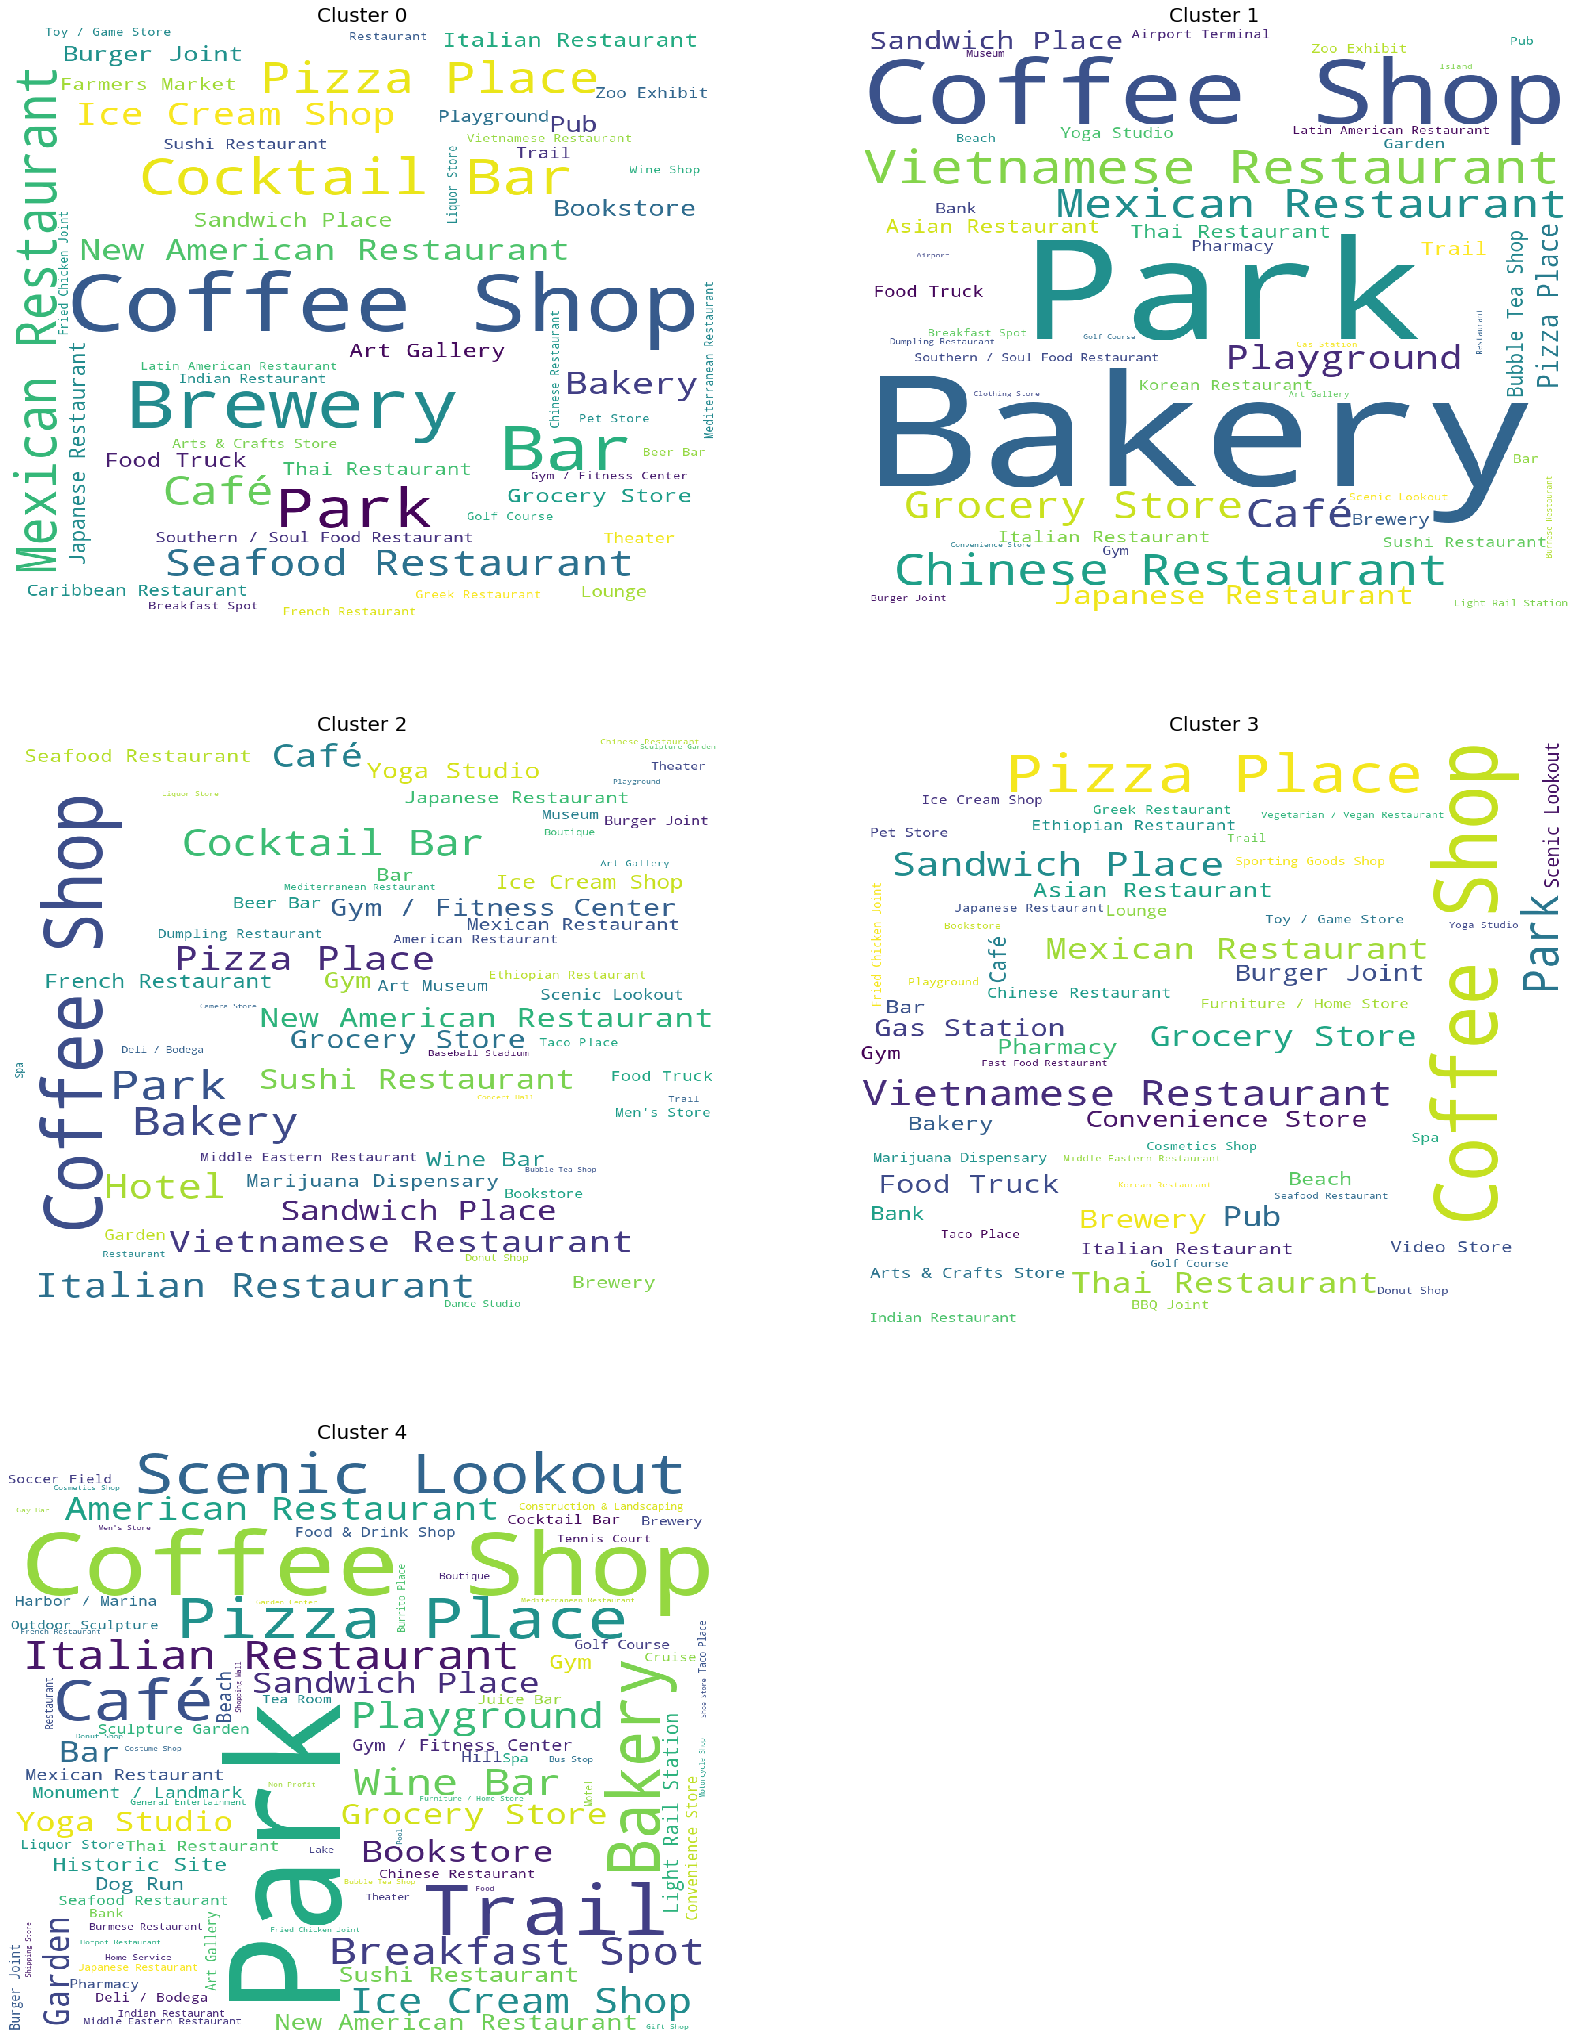

In [76]:
showWordCloud(cluster_by_venue_type)

## Results
#### Please see results section in full report, located at https://docs.google.com/document/d/1qOBW4ukXJYyemHXRjviA_QO2ZGPtrWzynAtz49dqKZc/edit?usp=sharing